In [103]:
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline
import torch
from diffusers import UniPCMultistepScheduler
import os
import torchvision.transforms.functional as F
from diffusers import StableDiffusionControlNetInpaintPipeline

ImportError: cannot import name 'StableDiffusionControlNetInpaintPipeline' from 'diffusers' (/home/ubuntu/anaconda3/lib/python3.9/site-packages/diffusers/__init__.py)

In [102]:
!which python
!/home/ubuntu/anaconda3/bin/pip install git+https://github.com/huggingface/diffusers
# !/usr/bin/pip install transformers
# import sys
# print(sys.path)
# !/home/ubuntu/anaconda3/bin/pip install transformers

/home/ubuntu/anaconda3/bin/python
Error processing line 1 of /home/ubuntu/anaconda3/lib/python3.9/site-packages/vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "/home/ubuntu/anaconda3/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-x10qr7ct
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-x10qr7ct
  Resolved https://github.com/huggingface/diffusers to commit fdcff560d006042879ed42f80874edd55a081bd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Version 1.1: Controlnet hed (无LORA)
# Version 1.2: Controlnet hed (有LORA)

exp_name = "0319_v1.2"

use_lora = ("v1.2" in exp_name)

发现Lora没啥用

输入每一帧Hed图像，直接根据视频跑图生图


In [87]:
# root folder

root_path = "/home/ubuntu/AI二次元/0319_jiaran_yao"

# 视频图片
video_img_path = os.path.join(root_path, "input_images")

# hed图片位置
hed_img_path = os.path.join(root_path, "transfered_images")

# 实验名称

exp_name = "0319_v1.2"

use_lora = ("v1.2" in exp_name)

# 将会保存到 output_images和processed.mp4
# /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.1/processed.mp4
# /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.1/output_images/

# 输出文件夹地址

output_path = os.path.join(root_path, exp_name)

if not os.path.exists(output_path):
    os.mkdir(output_path)
    print("create folder", output_path)
else:
    print("sorry, folder exists, change exp_name")
    print("folder", output_path)
# 输出视频地址
output_video_path = os.path.join(output_path, "processed.mp4")

# 输出图片地址
output_img_path = os.path.join(output_path, "output_images")
if not os.path.exists(output_img_path):
    os.mkdir(output_img_path)

sorry, folder exists, change exp_name
folder /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2


In [88]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "gsdf/Counterfeit-V2.5", controlnet=controlnet, torch_dtype=torch.float16
)
if use_lora:
    bin_path = "/home/ubuntu/diffusers/JiaranLora/Jiaran.bin"
    pipe.unet.load_attn_procs(bin_path)
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

In [89]:
# 获取图片总数
video_img_list = os.listdir(video_img_path)
hed_img_list = os.listdir(hed_img_path)
img_num = len(file_list)
img_num

300

## 生成第一帧检查一下

1.png


  0%|          | 0/20 [00:00<?, ?it/s]

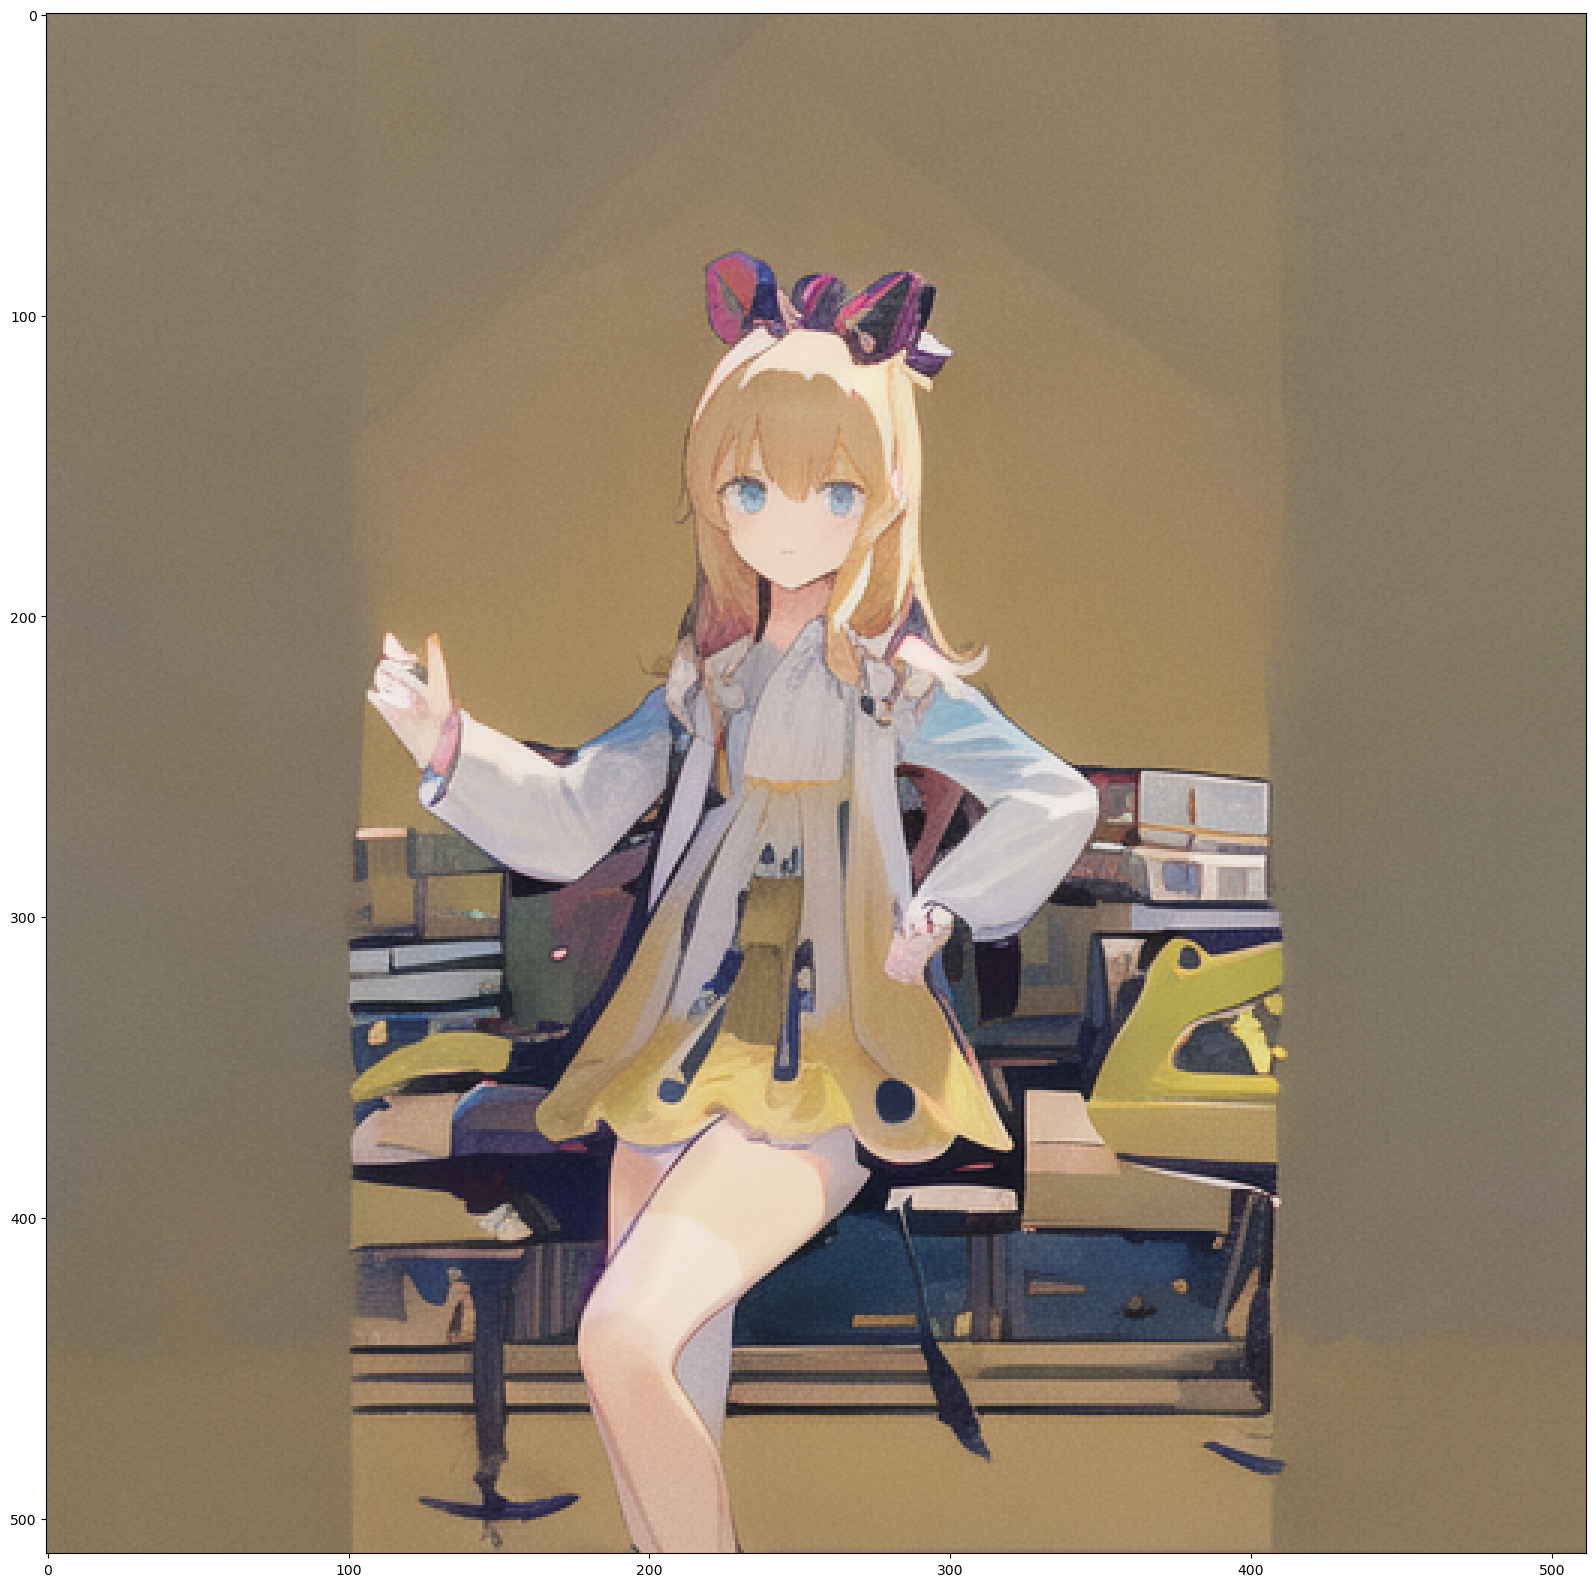

In [99]:

i = 1
filename = str(i) + ".png"
print(filename)
file_path = os.path.join(hed_img_path, filename)
hed_image = SquarePad()(hed_image)
hed_image = F.resize(hed_image, size=(512,512))

hed_image.size
hed_image

torch.manual_seed(32)
# prompt = "masterpiece, best quality, 1girl, solo, dynamic pose, brown hair, blue eyes, long hair, red hair bow, JiaranDianaLoraASOUL_v20SingleCostume, light smile, closed mouth, clean background"
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output = pipe(
    prompt,
    hed_image,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)
output
plt.figure(figsize=(20,20))
plt.imshow(output[0][0])

##  生成所有图片

In [92]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')

In [93]:
for i in range(300):
    filename = str(i+1) + ".png"
    print(filename)
    file_path = os.path.join(hed_img_path, filename)
    hed_image = Image.open(file_path)
    hed_image = SquarePad()(hed_image)
    hed_image = F.resize(hed_image, size=(512,512)) 
    torch.manual_seed(32)
    prompt = "masterpiece, best quality, 1girl, solo, dynamic pose, brown hair, blue eyes, long hair, red hair bow, JiaranDianaLoraASOUL_v20SingleCostume, light smile, cute mouth, clean background"
    negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
    output = pipe(
        prompt,
        hed_image,
        negative_prompt=negative_prompt,
        num_inference_steps=20,
    )
    output[0][0].save(os.path.join(output_img_path, filename))


1.png


  0%|          | 0/20 [00:00<?, ?it/s]

2.png


  0%|          | 0/20 [00:00<?, ?it/s]

3.png


  0%|          | 0/20 [00:00<?, ?it/s]

4.png


  0%|          | 0/20 [00:00<?, ?it/s]

5.png


  0%|          | 0/20 [00:00<?, ?it/s]

6.png


  0%|          | 0/20 [00:00<?, ?it/s]

7.png


  0%|          | 0/20 [00:00<?, ?it/s]

8.png


  0%|          | 0/20 [00:00<?, ?it/s]

9.png


  0%|          | 0/20 [00:00<?, ?it/s]

10.png


  0%|          | 0/20 [00:00<?, ?it/s]

11.png


  0%|          | 0/20 [00:00<?, ?it/s]

12.png


  0%|          | 0/20 [00:00<?, ?it/s]

13.png


  0%|          | 0/20 [00:00<?, ?it/s]

14.png


  0%|          | 0/20 [00:00<?, ?it/s]

15.png


  0%|          | 0/20 [00:00<?, ?it/s]

16.png


  0%|          | 0/20 [00:00<?, ?it/s]

17.png


  0%|          | 0/20 [00:00<?, ?it/s]

18.png


  0%|          | 0/20 [00:00<?, ?it/s]

19.png


  0%|          | 0/20 [00:00<?, ?it/s]

20.png


  0%|          | 0/20 [00:00<?, ?it/s]

21.png


  0%|          | 0/20 [00:00<?, ?it/s]

22.png


  0%|          | 0/20 [00:00<?, ?it/s]

23.png


  0%|          | 0/20 [00:00<?, ?it/s]

24.png


  0%|          | 0/20 [00:00<?, ?it/s]

25.png


  0%|          | 0/20 [00:00<?, ?it/s]

26.png


  0%|          | 0/20 [00:00<?, ?it/s]

27.png


  0%|          | 0/20 [00:00<?, ?it/s]

28.png


  0%|          | 0/20 [00:00<?, ?it/s]

29.png


  0%|          | 0/20 [00:00<?, ?it/s]

30.png


  0%|          | 0/20 [00:00<?, ?it/s]

31.png


  0%|          | 0/20 [00:00<?, ?it/s]

32.png


  0%|          | 0/20 [00:00<?, ?it/s]

33.png


  0%|          | 0/20 [00:00<?, ?it/s]

34.png


  0%|          | 0/20 [00:00<?, ?it/s]

35.png


  0%|          | 0/20 [00:00<?, ?it/s]

36.png


  0%|          | 0/20 [00:00<?, ?it/s]

37.png


  0%|          | 0/20 [00:00<?, ?it/s]

38.png


  0%|          | 0/20 [00:00<?, ?it/s]

39.png


  0%|          | 0/20 [00:00<?, ?it/s]

40.png


  0%|          | 0/20 [00:00<?, ?it/s]

41.png


  0%|          | 0/20 [00:00<?, ?it/s]

42.png


  0%|          | 0/20 [00:00<?, ?it/s]

43.png


  0%|          | 0/20 [00:00<?, ?it/s]

44.png


  0%|          | 0/20 [00:00<?, ?it/s]

45.png


  0%|          | 0/20 [00:00<?, ?it/s]

46.png


  0%|          | 0/20 [00:00<?, ?it/s]

47.png


  0%|          | 0/20 [00:00<?, ?it/s]

48.png


  0%|          | 0/20 [00:00<?, ?it/s]

49.png


  0%|          | 0/20 [00:00<?, ?it/s]

50.png


  0%|          | 0/20 [00:00<?, ?it/s]

51.png


  0%|          | 0/20 [00:00<?, ?it/s]

52.png


  0%|          | 0/20 [00:00<?, ?it/s]

53.png


  0%|          | 0/20 [00:00<?, ?it/s]

54.png


  0%|          | 0/20 [00:00<?, ?it/s]

55.png


  0%|          | 0/20 [00:00<?, ?it/s]

56.png


  0%|          | 0/20 [00:00<?, ?it/s]

57.png


  0%|          | 0/20 [00:00<?, ?it/s]

58.png


  0%|          | 0/20 [00:00<?, ?it/s]

59.png


  0%|          | 0/20 [00:00<?, ?it/s]

60.png


  0%|          | 0/20 [00:00<?, ?it/s]

61.png


  0%|          | 0/20 [00:00<?, ?it/s]

62.png


  0%|          | 0/20 [00:00<?, ?it/s]

63.png


  0%|          | 0/20 [00:00<?, ?it/s]

64.png


  0%|          | 0/20 [00:00<?, ?it/s]

65.png


  0%|          | 0/20 [00:00<?, ?it/s]

66.png


  0%|          | 0/20 [00:00<?, ?it/s]

67.png


  0%|          | 0/20 [00:00<?, ?it/s]

68.png


  0%|          | 0/20 [00:00<?, ?it/s]

69.png


  0%|          | 0/20 [00:00<?, ?it/s]

70.png


  0%|          | 0/20 [00:00<?, ?it/s]

71.png


  0%|          | 0/20 [00:00<?, ?it/s]

72.png


  0%|          | 0/20 [00:00<?, ?it/s]

73.png


  0%|          | 0/20 [00:00<?, ?it/s]

74.png


  0%|          | 0/20 [00:00<?, ?it/s]

75.png


  0%|          | 0/20 [00:00<?, ?it/s]

76.png


  0%|          | 0/20 [00:00<?, ?it/s]

77.png


  0%|          | 0/20 [00:00<?, ?it/s]

78.png


  0%|          | 0/20 [00:00<?, ?it/s]

79.png


  0%|          | 0/20 [00:00<?, ?it/s]

80.png


  0%|          | 0/20 [00:00<?, ?it/s]

81.png


  0%|          | 0/20 [00:00<?, ?it/s]

82.png


  0%|          | 0/20 [00:00<?, ?it/s]

83.png


  0%|          | 0/20 [00:00<?, ?it/s]

84.png


  0%|          | 0/20 [00:00<?, ?it/s]

85.png


  0%|          | 0/20 [00:00<?, ?it/s]

86.png


  0%|          | 0/20 [00:00<?, ?it/s]

87.png


  0%|          | 0/20 [00:00<?, ?it/s]

88.png


  0%|          | 0/20 [00:00<?, ?it/s]

89.png


  0%|          | 0/20 [00:00<?, ?it/s]

90.png


  0%|          | 0/20 [00:00<?, ?it/s]

91.png


  0%|          | 0/20 [00:00<?, ?it/s]

92.png


  0%|          | 0/20 [00:00<?, ?it/s]

93.png


  0%|          | 0/20 [00:00<?, ?it/s]

94.png


  0%|          | 0/20 [00:00<?, ?it/s]

95.png


  0%|          | 0/20 [00:00<?, ?it/s]

96.png


  0%|          | 0/20 [00:00<?, ?it/s]

97.png


  0%|          | 0/20 [00:00<?, ?it/s]

98.png


  0%|          | 0/20 [00:00<?, ?it/s]

99.png


  0%|          | 0/20 [00:00<?, ?it/s]

100.png


  0%|          | 0/20 [00:00<?, ?it/s]

101.png


  0%|          | 0/20 [00:00<?, ?it/s]

102.png


  0%|          | 0/20 [00:00<?, ?it/s]

103.png


  0%|          | 0/20 [00:00<?, ?it/s]

104.png


  0%|          | 0/20 [00:00<?, ?it/s]

105.png


  0%|          | 0/20 [00:00<?, ?it/s]

106.png


  0%|          | 0/20 [00:00<?, ?it/s]

107.png


  0%|          | 0/20 [00:00<?, ?it/s]

108.png


  0%|          | 0/20 [00:00<?, ?it/s]

109.png


  0%|          | 0/20 [00:00<?, ?it/s]

110.png


  0%|          | 0/20 [00:00<?, ?it/s]

111.png


  0%|          | 0/20 [00:00<?, ?it/s]

112.png


  0%|          | 0/20 [00:00<?, ?it/s]

113.png


  0%|          | 0/20 [00:00<?, ?it/s]

114.png


  0%|          | 0/20 [00:00<?, ?it/s]

115.png


  0%|          | 0/20 [00:00<?, ?it/s]

116.png


  0%|          | 0/20 [00:00<?, ?it/s]

117.png


  0%|          | 0/20 [00:00<?, ?it/s]

118.png


  0%|          | 0/20 [00:00<?, ?it/s]

119.png


  0%|          | 0/20 [00:00<?, ?it/s]

120.png


  0%|          | 0/20 [00:00<?, ?it/s]

121.png


  0%|          | 0/20 [00:00<?, ?it/s]

122.png


  0%|          | 0/20 [00:00<?, ?it/s]

123.png


  0%|          | 0/20 [00:00<?, ?it/s]

124.png


  0%|          | 0/20 [00:00<?, ?it/s]

125.png


  0%|          | 0/20 [00:00<?, ?it/s]

126.png


  0%|          | 0/20 [00:00<?, ?it/s]

127.png


  0%|          | 0/20 [00:00<?, ?it/s]

128.png


  0%|          | 0/20 [00:00<?, ?it/s]

129.png


  0%|          | 0/20 [00:00<?, ?it/s]

130.png


  0%|          | 0/20 [00:00<?, ?it/s]

131.png


  0%|          | 0/20 [00:00<?, ?it/s]

132.png


  0%|          | 0/20 [00:00<?, ?it/s]

133.png


  0%|          | 0/20 [00:00<?, ?it/s]

134.png


  0%|          | 0/20 [00:00<?, ?it/s]

135.png


  0%|          | 0/20 [00:00<?, ?it/s]

136.png


  0%|          | 0/20 [00:00<?, ?it/s]

137.png


  0%|          | 0/20 [00:00<?, ?it/s]

138.png


  0%|          | 0/20 [00:00<?, ?it/s]

139.png


  0%|          | 0/20 [00:00<?, ?it/s]

140.png


  0%|          | 0/20 [00:00<?, ?it/s]

141.png


  0%|          | 0/20 [00:00<?, ?it/s]

142.png


  0%|          | 0/20 [00:00<?, ?it/s]

143.png


  0%|          | 0/20 [00:00<?, ?it/s]

144.png


  0%|          | 0/20 [00:00<?, ?it/s]

145.png


  0%|          | 0/20 [00:00<?, ?it/s]

146.png


  0%|          | 0/20 [00:00<?, ?it/s]

147.png


  0%|          | 0/20 [00:00<?, ?it/s]

148.png


  0%|          | 0/20 [00:00<?, ?it/s]

149.png


  0%|          | 0/20 [00:00<?, ?it/s]

150.png


  0%|          | 0/20 [00:00<?, ?it/s]

151.png


  0%|          | 0/20 [00:00<?, ?it/s]

152.png


  0%|          | 0/20 [00:00<?, ?it/s]

153.png


  0%|          | 0/20 [00:00<?, ?it/s]

154.png


  0%|          | 0/20 [00:00<?, ?it/s]

155.png


  0%|          | 0/20 [00:00<?, ?it/s]

156.png


  0%|          | 0/20 [00:00<?, ?it/s]

157.png


  0%|          | 0/20 [00:00<?, ?it/s]

158.png


  0%|          | 0/20 [00:00<?, ?it/s]

159.png


  0%|          | 0/20 [00:00<?, ?it/s]

160.png


  0%|          | 0/20 [00:00<?, ?it/s]

161.png


  0%|          | 0/20 [00:00<?, ?it/s]

162.png


  0%|          | 0/20 [00:00<?, ?it/s]

163.png


  0%|          | 0/20 [00:00<?, ?it/s]

164.png


  0%|          | 0/20 [00:00<?, ?it/s]

165.png


  0%|          | 0/20 [00:00<?, ?it/s]

166.png


  0%|          | 0/20 [00:00<?, ?it/s]

167.png


  0%|          | 0/20 [00:00<?, ?it/s]

168.png


  0%|          | 0/20 [00:00<?, ?it/s]

169.png


  0%|          | 0/20 [00:00<?, ?it/s]

170.png


  0%|          | 0/20 [00:00<?, ?it/s]

171.png


  0%|          | 0/20 [00:00<?, ?it/s]

172.png


  0%|          | 0/20 [00:00<?, ?it/s]

173.png


  0%|          | 0/20 [00:00<?, ?it/s]

174.png


  0%|          | 0/20 [00:00<?, ?it/s]

175.png


  0%|          | 0/20 [00:00<?, ?it/s]

176.png


  0%|          | 0/20 [00:00<?, ?it/s]

177.png


  0%|          | 0/20 [00:00<?, ?it/s]

178.png


  0%|          | 0/20 [00:00<?, ?it/s]

179.png


  0%|          | 0/20 [00:00<?, ?it/s]

180.png


  0%|          | 0/20 [00:00<?, ?it/s]

181.png


  0%|          | 0/20 [00:00<?, ?it/s]

182.png


  0%|          | 0/20 [00:00<?, ?it/s]

183.png


  0%|          | 0/20 [00:00<?, ?it/s]

184.png


  0%|          | 0/20 [00:00<?, ?it/s]

185.png


  0%|          | 0/20 [00:00<?, ?it/s]

186.png


  0%|          | 0/20 [00:00<?, ?it/s]

187.png


  0%|          | 0/20 [00:00<?, ?it/s]

188.png


  0%|          | 0/20 [00:00<?, ?it/s]

189.png


  0%|          | 0/20 [00:00<?, ?it/s]

190.png


  0%|          | 0/20 [00:00<?, ?it/s]

191.png


  0%|          | 0/20 [00:00<?, ?it/s]

192.png


  0%|          | 0/20 [00:00<?, ?it/s]

193.png


  0%|          | 0/20 [00:00<?, ?it/s]

194.png


  0%|          | 0/20 [00:00<?, ?it/s]

195.png


  0%|          | 0/20 [00:00<?, ?it/s]

196.png


  0%|          | 0/20 [00:00<?, ?it/s]

197.png


  0%|          | 0/20 [00:00<?, ?it/s]

198.png


  0%|          | 0/20 [00:00<?, ?it/s]

199.png


  0%|          | 0/20 [00:00<?, ?it/s]

200.png


  0%|          | 0/20 [00:00<?, ?it/s]

201.png


  0%|          | 0/20 [00:00<?, ?it/s]

202.png


  0%|          | 0/20 [00:00<?, ?it/s]

203.png


  0%|          | 0/20 [00:00<?, ?it/s]

204.png


  0%|          | 0/20 [00:00<?, ?it/s]

205.png


  0%|          | 0/20 [00:00<?, ?it/s]

206.png


  0%|          | 0/20 [00:00<?, ?it/s]

207.png


  0%|          | 0/20 [00:00<?, ?it/s]

208.png


  0%|          | 0/20 [00:00<?, ?it/s]

209.png


  0%|          | 0/20 [00:00<?, ?it/s]

210.png


  0%|          | 0/20 [00:00<?, ?it/s]

211.png


  0%|          | 0/20 [00:00<?, ?it/s]

212.png


  0%|          | 0/20 [00:00<?, ?it/s]

213.png


  0%|          | 0/20 [00:00<?, ?it/s]

214.png


  0%|          | 0/20 [00:00<?, ?it/s]

215.png


  0%|          | 0/20 [00:00<?, ?it/s]

216.png


  0%|          | 0/20 [00:00<?, ?it/s]

217.png


  0%|          | 0/20 [00:00<?, ?it/s]

218.png


  0%|          | 0/20 [00:00<?, ?it/s]

219.png


  0%|          | 0/20 [00:00<?, ?it/s]

220.png


  0%|          | 0/20 [00:00<?, ?it/s]

221.png


  0%|          | 0/20 [00:00<?, ?it/s]

222.png


  0%|          | 0/20 [00:00<?, ?it/s]

223.png


  0%|          | 0/20 [00:00<?, ?it/s]

224.png


  0%|          | 0/20 [00:00<?, ?it/s]

225.png


  0%|          | 0/20 [00:00<?, ?it/s]

226.png


  0%|          | 0/20 [00:00<?, ?it/s]

227.png


  0%|          | 0/20 [00:00<?, ?it/s]

228.png


  0%|          | 0/20 [00:00<?, ?it/s]

229.png


  0%|          | 0/20 [00:00<?, ?it/s]

230.png


  0%|          | 0/20 [00:00<?, ?it/s]

231.png


  0%|          | 0/20 [00:00<?, ?it/s]

232.png


  0%|          | 0/20 [00:00<?, ?it/s]

233.png


  0%|          | 0/20 [00:00<?, ?it/s]

234.png


  0%|          | 0/20 [00:00<?, ?it/s]

235.png


  0%|          | 0/20 [00:00<?, ?it/s]

236.png


  0%|          | 0/20 [00:00<?, ?it/s]

237.png


  0%|          | 0/20 [00:00<?, ?it/s]

238.png


  0%|          | 0/20 [00:00<?, ?it/s]

239.png


  0%|          | 0/20 [00:00<?, ?it/s]

240.png


  0%|          | 0/20 [00:00<?, ?it/s]

241.png


  0%|          | 0/20 [00:00<?, ?it/s]

242.png


  0%|          | 0/20 [00:00<?, ?it/s]

243.png


  0%|          | 0/20 [00:00<?, ?it/s]

244.png


  0%|          | 0/20 [00:00<?, ?it/s]

245.png


  0%|          | 0/20 [00:00<?, ?it/s]

246.png


  0%|          | 0/20 [00:00<?, ?it/s]

247.png


  0%|          | 0/20 [00:00<?, ?it/s]

248.png


  0%|          | 0/20 [00:00<?, ?it/s]

249.png


  0%|          | 0/20 [00:00<?, ?it/s]

250.png


  0%|          | 0/20 [00:00<?, ?it/s]

251.png


  0%|          | 0/20 [00:00<?, ?it/s]

252.png


  0%|          | 0/20 [00:00<?, ?it/s]

253.png


  0%|          | 0/20 [00:00<?, ?it/s]

254.png


  0%|          | 0/20 [00:00<?, ?it/s]

255.png


  0%|          | 0/20 [00:00<?, ?it/s]

256.png


  0%|          | 0/20 [00:00<?, ?it/s]

257.png


  0%|          | 0/20 [00:00<?, ?it/s]

258.png


  0%|          | 0/20 [00:00<?, ?it/s]

259.png


  0%|          | 0/20 [00:00<?, ?it/s]

260.png


  0%|          | 0/20 [00:00<?, ?it/s]

261.png


  0%|          | 0/20 [00:00<?, ?it/s]

262.png


  0%|          | 0/20 [00:00<?, ?it/s]

263.png


  0%|          | 0/20 [00:00<?, ?it/s]

264.png


  0%|          | 0/20 [00:00<?, ?it/s]

265.png


  0%|          | 0/20 [00:00<?, ?it/s]

266.png


  0%|          | 0/20 [00:00<?, ?it/s]

267.png


  0%|          | 0/20 [00:00<?, ?it/s]

268.png


  0%|          | 0/20 [00:00<?, ?it/s]

269.png


  0%|          | 0/20 [00:00<?, ?it/s]

270.png


  0%|          | 0/20 [00:00<?, ?it/s]

271.png


  0%|          | 0/20 [00:00<?, ?it/s]

272.png


  0%|          | 0/20 [00:00<?, ?it/s]

273.png


  0%|          | 0/20 [00:00<?, ?it/s]

274.png


  0%|          | 0/20 [00:00<?, ?it/s]

275.png


  0%|          | 0/20 [00:00<?, ?it/s]

276.png


  0%|          | 0/20 [00:00<?, ?it/s]

277.png


  0%|          | 0/20 [00:00<?, ?it/s]

278.png


  0%|          | 0/20 [00:00<?, ?it/s]

279.png


  0%|          | 0/20 [00:00<?, ?it/s]

280.png


  0%|          | 0/20 [00:00<?, ?it/s]

281.png


  0%|          | 0/20 [00:00<?, ?it/s]

282.png


  0%|          | 0/20 [00:00<?, ?it/s]

283.png


  0%|          | 0/20 [00:00<?, ?it/s]

284.png


  0%|          | 0/20 [00:00<?, ?it/s]

285.png


  0%|          | 0/20 [00:00<?, ?it/s]

286.png


  0%|          | 0/20 [00:00<?, ?it/s]

287.png


  0%|          | 0/20 [00:00<?, ?it/s]

288.png


  0%|          | 0/20 [00:00<?, ?it/s]

289.png


  0%|          | 0/20 [00:00<?, ?it/s]

290.png


  0%|          | 0/20 [00:00<?, ?it/s]

291.png


  0%|          | 0/20 [00:00<?, ?it/s]

292.png


  0%|          | 0/20 [00:00<?, ?it/s]

293.png


  0%|          | 0/20 [00:00<?, ?it/s]

294.png


  0%|          | 0/20 [00:00<?, ?it/s]

295.png


  0%|          | 0/20 [00:00<?, ?it/s]

296.png


  0%|          | 0/20 [00:00<?, ?it/s]

297.png


  0%|          | 0/20 [00:00<?, ?it/s]

298.png


  0%|          | 0/20 [00:00<?, ?it/s]

299.png


  0%|          | 0/20 [00:00<?, ?it/s]

300.png


  0%|          | 0/20 [00:00<?, ?it/s]

## 生成视频

In [96]:
fps = 30

# 获取图片总数
file_list = os.listdir(output_img_path)
file_num = len(file_list)

# 获取视频长宽
item = os.path.join(output_img_path, str(1) + '.png')
width, height, _ = cv2.imread(item).shape
print(width, height)
video = cv2.VideoWriter(output_video_path,  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps, (height, width))  # 创建视频流对象


for i in range(file_num):
    item = os.path.join(output_img_path, str(i + 1) + '.png')
    if os.path.exists(item):
        print("read",item)
#         print(cv2.imread(item).shape)
        video.write(cv2.imread(item))  # 把图片写进视频
video.release()  # 释放

512 512
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/1.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/2.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/3.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/4.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/5.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/6.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/7.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/8.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/9.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/10.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/11.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/12.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/13.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/14.png
read /h

read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/131.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/132.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/133.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/134.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/135.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/136.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/137.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/138.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/139.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/140.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/141.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/142.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/143.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/

read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/263.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/264.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/265.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/266.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/267.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/268.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/269.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/270.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/271.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/272.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/273.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/274.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/275.png
read /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/output_images/

In [95]:
print("output video is here", output_video_path)

output video is here /home/ubuntu/AI二次元/0319_jiaran_yao/0319_v1.2/processed.mp4


# Version 2: Controlnet image2image
## Version 2.1 : Controlnet image2image 无Lora
## Version 2: Controlnet image2image 有Lora

输入每一帧Hed图像，直接根据视频跑图生图

In [100]:
pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained("./diffusers/control_sd15_seg",torch_dtype=torch.float16).to('cuda')
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",torch_dtype=torch.float16).to('cuda')

# yes, we can directly replace the UNet
pipe_control.unet = pipe_inpaint.unet
pipe_control.unet.in_channels = 4

# we also the same example as stable-diffusion-inpainting
image = load_image("https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png")
mask = load_image("https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png")

# the segmentation result is generated from https://huggingface.co/spaces/hysts/ControlNet
control_image = load_image('tmptvkkr0tg.png')

image = pipe_control(prompt="Face of a yellow cat, high resolution, sitting on a park bench", 
                     negative_prompt="lowres, bad anatomy, worst quality, low quality",
                     controlnet_hint=control_image, 
                     image=image,
                     mask_image=mask,
                     num_inference_steps=100).images[0]

image.save("inpaint_seg.jpg")

NameError: name 'StableDiffusionControlNetInpaintPipeline' is not defined